In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json
import os
import re

In [2]:
RESULTS_DIR = 'results'

In [3]:
def get_expected_n(beta, fixed_n = 30, n_looks = 2, spending_type = 'asP'):
    '''
    Arguments
    ---------
    beta : float
        The Type II error of the fixed sample design
        that's power you're trying to match.
    n_looks : int
        The number of (evenly spaced) looks at the data.
    spending_type : 'asP' | 'asOF', default: 'asP'
        'asP' uses a Pocock spending function (default)
        'asOF' uses an OBrien Fleming spending function


    Notes
    -------
    Requires R to be installed in your environment.

    '''
    from rpy2 import robjects
    fv = robjects.r(
        '''
        if (!('rpact' %%in%% installed.packages())) {
            install.packages(
                'rpact', type = 'source',
                repos = 'http://cran.us.r-project.org'
            )
        }
        design <- rpact::getDesignGroupSequential(
            kMax = %d, beta = %f, typeOfDesign = '%s'
        )
        chars <- rpact::getDesignCharacteristics(design)
        chars$averageSampleNumber1
        '''%(n_looks, beta, spending_type)
    )
    return fixed_n*fv[0]

In [4]:
def read_json(fp):
    with open(fp, 'r') as f:
        d = json.load(f)
    return d

def load_results(results_dir, test_type):
    fnames = [f for f in os.listdir(results_dir) if test_type in f]
    fpaths = [os.path.join(RESULTS_DIR, f) for f in fnames]
    effects = [re.findall('(\w+)_\w+.json', f)[0] for f in fnames]
    res = [read_json(f) for f in fpaths]
    power_fixed = [r['power_fixed'] for r in res]
    power_sequential = [r['cumulative_power'][-1] for r in res]
    n_exp = [r['n_expected'] for r in res]
    n_fixed = [r['n_fixed'] for r in res]
    df = pd.DataFrame(dict(
        effect = effects,
        power_fixed = power_fixed,
        power_sequential = power_sequential,
        n_expected = n_exp,
        n_fixed = n_fixed
    ))
    return df

In [5]:
# compute the expected sample size vs. power curve 
pows = np.linspace(.1, .99) # for parametric alpha spending
betas = 1 - pows
n_exps_pred = [get_expected_n(beta) for beta in betas]

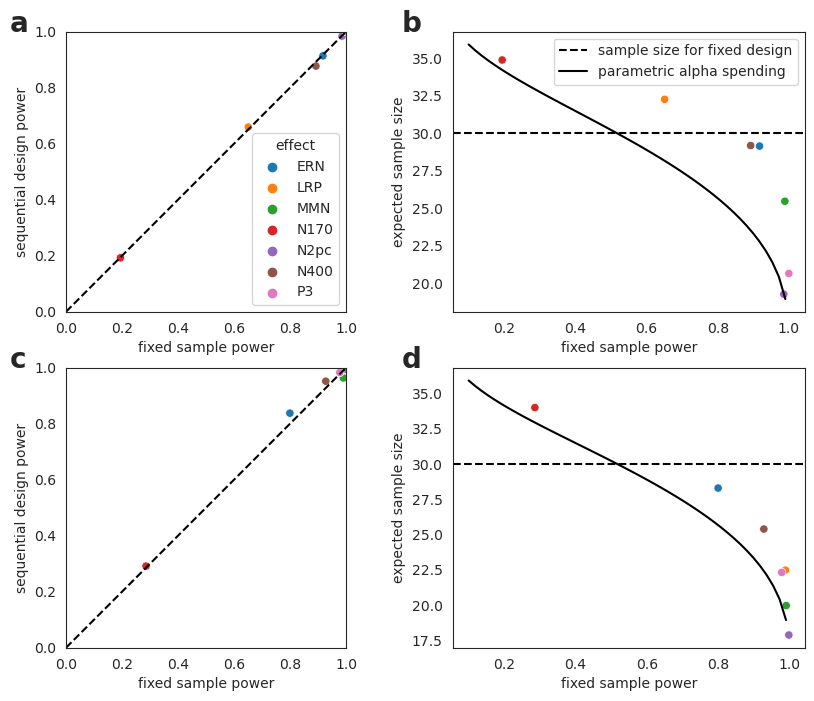

In [6]:
def plot_results(test_type, axs, show_legend = True):
    
    df = load_results(RESULTS_DIR, test_type)
    df.sort_values(by = ['effect'], inplace = True)
    
    ## plot power comparison
    axs[0].set_xlim(0, 1)
    axs[0].set_ylim(0, 1)
    axs[0].set_box_aspect(1)
    ax = sns.scatterplot(
        data = df,
        x = "power_fixed", y = "power_sequential", 
        hue = "effect",
        legend = 'auto' if show_legend else False,
        ax = axs[0]
    )
    if show_legend:
        sns.move_legend(ax, 'lower right')
    axs[0].plot([0, 1], [0, 1], '--', color = 'black', label = 'identity line')
    axs[0].set_xlabel('fixed sample power')
    axs[0].set_ylabel('sequential design power')
    
    ## plot expected sample size
    sns.scatterplot(
        data = df,
        x = "power_fixed", y = "n_expected", 
        hue = "effect",
        legend = False,
        ax = axs[1]
    )
    axs[1].axhline(
        df.n_fixed[0], 
        linestyle = '--', 
        color = 'black',
        label = 'sample size for fixed design'
    )
    axs[1].plot(
        pows, n_exps_pred, 
        color = 'black', 
        label = 'parametric alpha spending'
    )
    axs[1].set_xlabel('fixed sample power')
    axs[1].set_ylabel('expected sample size')
    if show_legend:
        axs[1].legend()
        
        

## plot simulation results
sns.set_style('white')
fig, axs = plt.subplots(2, 2, figsize = (10, 8))
plot_results('tmax', axs[0, :])
plot_results('cluster', axs[1, :], show_legend = False)
axs[0, 0].text(-0.2, 1, 'a', size = 20, weight = 'bold')
axs[0, 0].text(1.2, 1, 'b', size = 20, weight = 'bold')
axs[1, 0].text(-0.2, 1, 'c', size = 20, weight = 'bold')
axs[1, 0].text(1.2, 1, 'd', size = 20, weight = 'bold')
plt.savefig('power-simulations.jpeg', dpi = 500)
plt.show()